# Pseudobulk and differential expression analysis

## 1. Brief introduction

When cell lineage is clear (there are clear cell identity clusters), it might be beneficial to perform analyses at the pseudo-bulk level instead of the single-cell. By doing so, we recover lowly expressed genes that before were affected by the "drop-out" effect of single-cell. 

In this notebook, we showcase how to use `decoupler` to create pseudo-bulk samples from a human dataset, then perform differential expression analysis (DEA) between conditions using `PyDESeq2`. The data consists of ~5k Blood myeloid cells from healthy and COVID-19 infected patients available in the Single Cell Expression Atlas [here](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/results?plotType=umap&plotOption=20).

<div class="alert alert-info">

**Note**

This tutorial is populated (with updates) from the original `decoupler` [tutorial](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html). For downstream functional analysis following the DEA, check out the twin scverse tutorial `Functional analysis` and the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial of `decoupler`.

</div>  

## 2. Requirements
Besides scanpy, decoupler and pydeseq2, several dependencies might require installation:

  - pybiomart
  - PyComplexHeatmap
  - adjustText
  - marsilea-0.3.0

## 3. Package imports

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
, `decoupler` for creating pseudobulk samples and statistical methods, `pydeseq2` for
differential expression analysis.

In [1]:
import scanpy as sc
import decoupler as dc

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
# Import DefaultInference class to support multiple processes. 
# This behaviour might change in future update of DESeq2.
from pydeseq2.dds import DefaultInference

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt

# Needed for making heatmap alternative to decoupler.plot_associations().
import marsilea as ma
import marsilea.plotter as mp
from marsilea.plotter import MarkerMesh

## 4. General setup

Suppress warnings.

In [2]:
# Suppress warning.
import warnings
warnings.filterwarnings("ignore")

## 5. Data loading.

We can download the data easily using `scanpy`:

In [3]:
# Download data-set 
adata = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)

# Rename meta-data
columns = ['Sample Characteristic[sex]',
           'Sample Characteristic[individual]',
           'Sample Characteristic[disease]',
           'Factor Value[inferred cell type - ontology labels]']
adata.obs = adata.obs[columns]
adata.obs.columns = ['sex','individual','disease','cell_type']
adata

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'sex', 'individual', 'disease', 'cell_type'

## 6. Processing

This specific data-set contains ensmbl gene ids instead of gene symbols. 
To be able to use `decoupler` we need to transform them into gene symbols:

In [4]:
# Retrieve Biomart gene id-symbol mapping table. 
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name"], use_cache=False
    ).set_index("ensembl_gene_id")

# In case of API instability, the mapping table can be download from 
# https://github.com/scverse/scverse-tutorials/blob/main/docs/notebooks/data/ensembl_biomart_id2name.csv
# and manually imported as below.
# annot = pd.read_csv("./ensembl_biomart_id2name.csv", index_col=0)
# annot = annot.set_index("ensembl_gene_id")

In [5]:
# Filter genes not in annotation
adata = adata[:, adata.var.index.intersection(annot.index)]

# Assign gene symbols
adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
adata.var = adata.var.reset_index().rename(columns={'index': 'ensembl_gene_id'}).set_index('gene_symbol')

# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

# Remove duplicates
adata.var_names_make_unique()

Since the meta-data of this data-set is available, we can filter cells that were not annotated:

In [6]:
# Remove non-annotated cells
adata = adata[~adata.obs['cell_type'].isnull()]

We will store the raw counts in the `.layers` attribute so that we can use them
afterwards to generate pseudo-bulk profiles.

In [7]:
# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X

We can also look how cells cluster by cell identity:

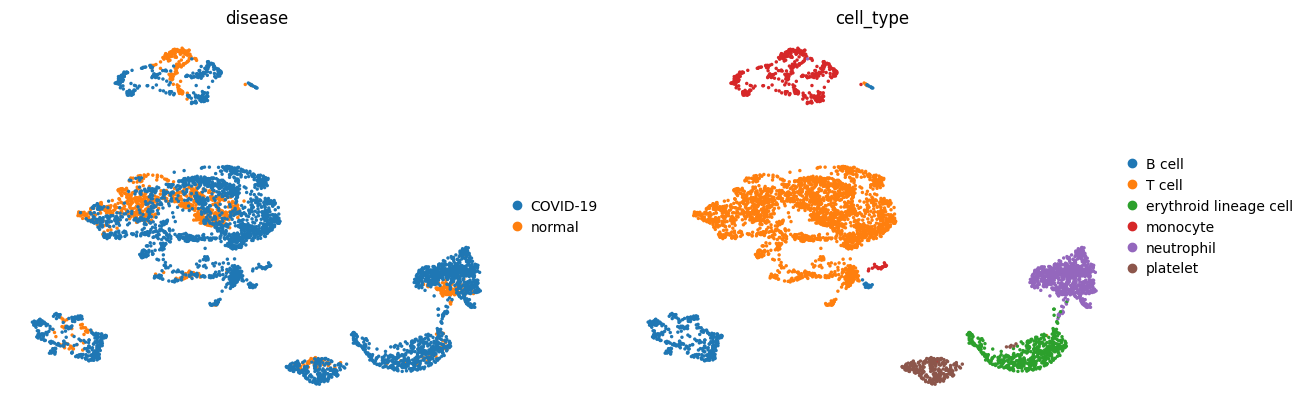

In [8]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual')

# Scale the data
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

# Generate UMAP features
sc.tl.umap(adata)

# Visualize
sc.pl.umap(adata, color=['disease','cell_type'], frameon=False)

In this data-set we have two condition, `COVID-19` and `healthy`, across 6 different cell types.

## 7. Generation of pseudo-bulk profiles

After the annotation of clusters into cell identities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterize them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results. 

The current best practice to correct for this is using a pseudo-bulk approach ([Squair J.W., et al 2021](https://doi.org/10.1038/s41467-021-25960-2)), which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

We can pseudobulk using the function `decoupler.get_pseudobulk`. In this example, we are interested in summing the counts but other
modes are available, for more information check its argument `mode`.

In [9]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 39 × 18413
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

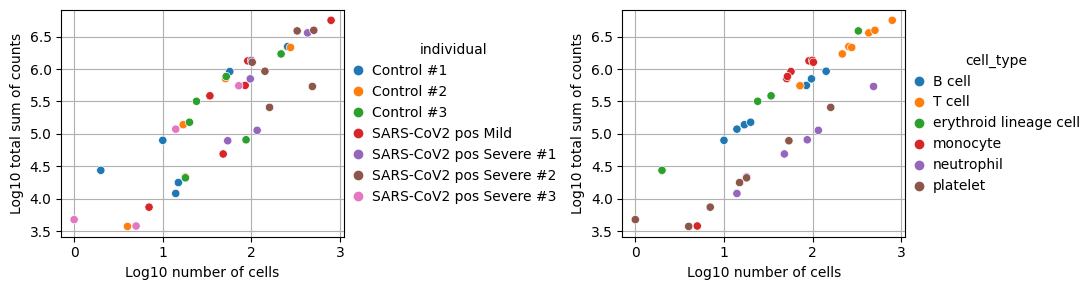

In [10]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'cell_type'], figsize=(11, 3))

There are two criteria to filter low quality samples: its number of cells (`psbulk_n_cells`), and its total sum of counts (`psbulk_counts`).
In these plots it can be seen that there are some samples of platelet cells that contain less than 10 cells, we might want to remove
them by using the arguments `min_cells` and `min_counts`. Note that these thresholds are arbitrary and will change depening on the
dataset, but a good rule of thumb is to have at least 10 cells with 1000 accumulated counts.

In [11]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 34 × 18413
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

### Exploration of pseudobulk profiles
Now that we have generated the pseudobulk profiles for each patient and each cell type, let's explore the variability between them. For that, we will first do some simple preprocessing and then do a PCA

In [12]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

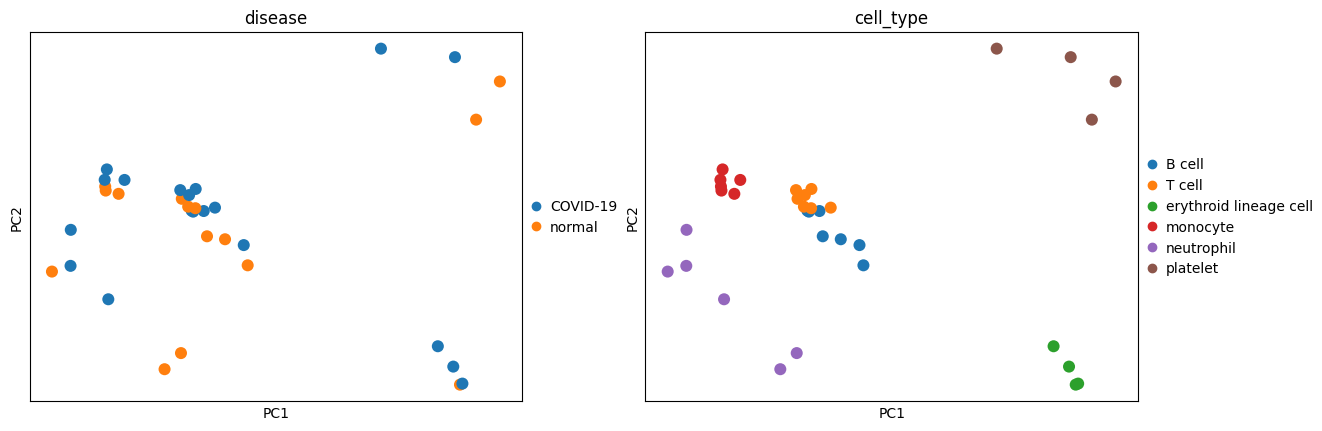

In [13]:
sc.pl.pca(pp_pdata, color=['disease', 'cell_type'], ncols=2, show=True, size=300)

When looking at the PCA, it seems like the two first components are able to easily separate cell types from one another, and it is therefore the main source of variability. In contrast, the principle components do not seem to be associated with disease status as such.

In order to have a better overview of the association of PCs with sample metadata, let's perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples

In [14]:
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = ['sex', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'], #metadata columns to associate to PCs
    obsm_key='X_pca',  # where the PCs are stored
    uns_key='pca_anova',  # where the results are stored
    inplace=True
)

100%|██████████| 10/10 [00:00<00:00, 42.12it/s]


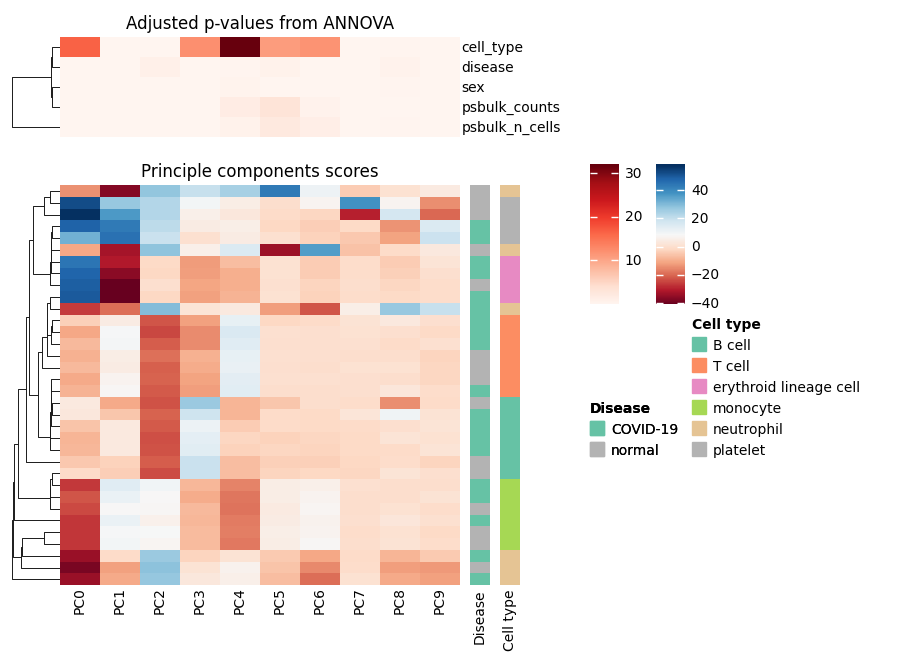

In [15]:
# In the original tutorial, the dc.plot_associations() was used, which at the time of this tutorial was broken.
# Use the alternative code instead until the dc.plot_associations() is fixed.

# plt.figure(figsize=(7,10))
# ax, legend_axes = dc.plot_associations(
#     pp_pdata,
#     uns_key='pca_anova',  # summary statistics from the anova tests
#     obsm_key='X_pca',  # where the PCs are stored
#     stat_col='p_adj',  # which summary statistic to plot
#     obs_annotation_cols = ['disease', 'cell_type'], # which sample annotations to plot
#     titles=['Adjusted p-values from ANOVA', 'Principle component scores']
# )
# plt.show()

pvals_df = pp_pdata.uns['pca_anova'].pivot(index='variable', columns='factor', values='p_adj').dropna()
neglog_p_df = pd.DataFrame(data=-np.log10(pvals_df.values),
                           index=list(pvals_df.index),
                           columns=list(pvals_df.columns))
pcs_df = pd.DataFrame(data=pp_pdata.obsm['X_pca'],
                      columns=[f'PC{ind}' for ind in range(10)],
                      index=pp_pdata.obs.index).reset_index().drop('index', axis=1)

h1 = ma.Heatmap(neglog_p_df, cmap="Reds", width=4, height=1, name="h1")
h1.add_title(top="Adjusted p-values from ANNOVA", align="center")
h1.add_legends()
h1.add_dendrogram("left")
h1.add_right(mp.Labels(neglog_p_df.index, fontsize=10))

h2 = ma.Heatmap(pcs_df.values, cmap="RdBu", width=0.4, height=4, name="h2")
h2.add_legends()
h2.add_dendrogram("left")
h2.add_title(top="Principle components scores", align="center")

disease_cat = list(pp_pdata.obs['disease'].values)
disease_colors = mp.Colors(disease_cat, cmap="Set2", label="Disease")

celltype_cat = list(pp_pdata.obs['cell_type'].values)
celltype_colors = mp.Colors(celltype_cat, cmap="Set2", label="Cell type")


h2.add_right(disease_colors, pad=0.1, size=0.2)
h2.add_right(celltype_colors, pad=0.1, size=0.2)
h2.add_bottom(mp.Labels(pcs_df.columns, fontsize=10))

c = (h1 / .2 / h2)
c.add_legends(side="right",
              stack_by='row', stack_size=2)
c.render()

On the PCA plots above, T and B cells seemed not to be that well separated. However when looking at the hierarchical clustering in the heatmap, one can see that the inclusion of more PCs helps to distinguish them.

When looking at the p-values from the ANOVA models, it becomes clear that the first 6 PCs are statistically associated with the cell type (with the exception of PC2). Overall, disease and other technical variables do not seem to affect the cells when looking only at the principle components.

### Pseudo-bulk profile gene filtering
Additionally to filtering low quality samples, we can also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. Note that this step should be done at the cell type level, since each cell type may express different collection of genes.

For this vignette, we will explore the effects of COVID on T cells. Let's first select our samples of interest:

In [16]:
# Select T cell profiles
tcells = pdata[pdata.obs['cell_type'] == 'T cell'].copy()

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

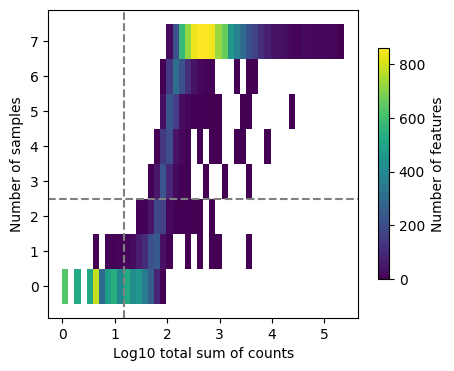

In [17]:
dc.plot_filter_by_expr(tcells, group='disease', min_count=10, min_total_count=15, min_prop=0.7)

Here we can observe the frequency of genes with different total sum of counts and number of samples. The dashed lines indicate the current thresholds, meaning that only the genes in the upper-right corner are going to be kept. Filtering parameters is completely arbitrary, but a good rule of thumb is to identify bimodal distributions and split them modifying the available thresholds.
In this example, with the default values we would keep a good quantity of genes while filtering potential noisy genes.

<div class="alert alert-info">

**Note**
    
Changing the value of `min_count` will drastically change the distribution of "Number of samples", not change its threshold.
In case you want to lower or increase it, you need to play with the `group`, `large_n` and `min_prop` parameters. 


</div>

Once we are content with the threshold parameters, we can perform the actual filtering:

In [18]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(tcells, group='disease', min_count=10, min_total_count=15, min_prop=0.7)

# Filter by these genes
tcells = tcells[:, genes].copy()
tcells

AnnData object with n_obs × n_vars = 7 × 10415
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented
in `decoupler.filter_by_prop`.

## 8. Contrast (DEA) between conditions
Once we have generated robust pseudo-bulk profiles, we can compute DEA. For this example, we will perform a simple
experimental design where we compare the gene expression of T cells from diseased patients against controls. We will use the
python implementation of the framework DESeq2, but we could have used any other one (`limma` or `edgeR` for example).
For a better understanding how it works, check [DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that
more complex experimental designs can be used by adding more factors to the `design_factors` argument.

In [19]:
# Build DESeq2 object.
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=tcells,
    design_factors='disease',
    ref_level=['disease', 'normal'],
    refit_cooks=True,
    inference=inference,
)

In [20]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.77 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 11.26 seconds.

Fitting LFCs...
... done in 1.18 seconds.

Refitting 0 outliers.



In [21]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["disease", 'COVID-19', 'normal'], inference=inference)

In [22]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: disease COVID-19 vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
A1BG          70.471703       -0.194916  0.222482 -0.876097  0.380977   
A2M           36.735027       -1.259308  0.327191 -3.848842  0.000119   
A2MP1         15.628274        0.616041  0.767779  0.802367  0.422340   
AAAS          18.305878        0.245297  0.413004  0.593935  0.552555   
AACS          24.630203        0.253113  0.335540  0.754344  0.450643   
...                 ...             ...       ...       ...       ...   
ZXDC          30.181501       -0.306623  0.318297 -0.963323  0.335385   
ZYG11B       101.884621        0.279126  0.337143  0.827915  0.407719   
ZYX           81.599907        0.292860  0.202160  1.448655  0.147434   
ZZEF1        820.790100        0.028608  0.233583  0.122474  0.902523   
ZZZ3          59.928497       -0.068270  0.275270 -0.248011

... done in 0.45 seconds.



In [23]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='disease_COVID-19_vs_normal')

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: disease COVID-19 vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
A1BG          70.471703       -0.082879  0.183383 -0.876097  0.380977   
A2M           36.735027       -1.071370  0.338611 -3.848842  0.000119   
A2MP1         15.628274        0.032486  0.289659  0.802367  0.422340   
AAAS          18.305878        0.040930  0.244828  0.593935  0.552555   
AACS          24.630203        0.060574  0.231249  0.754344  0.450643   
...                 ...             ...       ...       ...       ...   
ZXDC          30.181501       -0.080694  0.225169 -0.963323  0.335385   
ZYG11B       101.884621        0.065714  0.231680  0.827915  0.407719   
ZYX           81.599907        0.153035  0.187370  1.448655  0.147434   
ZZEF1        820.790100        0.011441  0.179296  0.122474  0.902523   
ZZZ3          59.928497       -0.020703  0.196577 -0

... done in 2.44 seconds.



In [24]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,70.471703,-0.082879,0.183383,-0.876097,0.380977,0.719800
A2M,36.735027,-1.071370,0.338611,-3.848842,0.000119,0.006269
A2MP1,15.628274,0.032486,0.289659,0.802367,0.422340,0.748127
AAAS,18.305878,0.040930,0.244828,0.593935,0.552555,0.827623
AACS,24.630203,0.060574,0.231249,0.754344,0.450643,0.766366
...,...,...,...,...,...,...
ZXDC,30.181501,-0.080694,0.225169,-0.963323,0.335385,0.687688
ZYG11B,101.884621,0.065714,0.231680,0.827915,0.407719,0.738730
ZYX,81.599907,0.153035,0.187370,1.448655,0.147434,0.487976


We can plot the obtained results in a volcano plot:

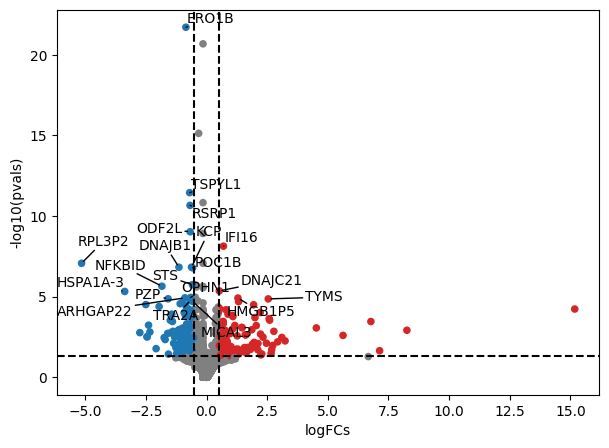

In [25]:
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [26]:
mat = results_df[['stat']].T.rename(index={'stat': 'T cell'})
mat

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,-0.876097,-3.848842,0.802367,0.593935,0.754344,-0.227301,-0.61717,0.294581,1.39611,0.505238,...,1.56492,1.396946,3.544967,-1.017032,-2.251387,-0.963323,0.827915,1.448655,0.122474,-0.248011


## 9. Final notes

#### Important links:

1)  [Downstream functional analysis](https://scverse.org/learn/)
2)  [decoupler tutorials](https://decoupler-py.readthedocs.io/en/latest/index.html)
3)  [pyDESeq2 documentation](https://pydeseq2.readthedocs.io/en/latest/)
4)  [sc-best-practice chapters](https://www.sc-best-practices.org/conditions/differential_gene_expression.html)

#### References:
1. [decoupleR](https://doi.org/10.1093/bioadv/vbac016)  Pau Badia-i-Mompel, Jesús Vélez Santiago, Jana Braunger, Celina Geiss, Daniel Dimitrov, Sophia Müller-Dott, Petr Taus, Aurelien Dugourd, Christian H Holland, Ricardo O Ramirez Flores, Julio Saez-Rodriguez, decoupleR: ensemble of computational methods to infer biological activities from omics data, Bioinformatics Advances, Volume 2, Issue 1, 2022, vbac016,



## 10. Acknowledgements:
Content of this tutorial was pulled from decoupler package docs.

Thank you to:

Badia-i-Mompel P., Vélez Santiago J., Braunger J., Geiss C., Dimitrov D., Müller-Dott S., Taus P., Dugourd A., Holland C.H., Ramirez Flores R.O. and Saez-Rodriguez J.

and all PyDESeq2 contributors.